# ISYE 6420 - Project

## 1. Introduction

Covid19 presented an unprecedented challenge for humans around the world. Policymakers were challenged by the ever growing, sometimes contradicting research on how its spread can be contained. Most popular strategies included government restrictions like “Stay at home”, “Workplace closing”, “Public event cancellations”. In this analysis these popular strategies are analyzed to estimate their impact on containing covid19 spread. It is very valuable for policymakers and even individuals to understand which methods are effective in containing this disease. Bayesian regression is explored in this analysis to understand the impact of policies on the forward looking average of newly confirmed covid-19 patients. Another hypothesis is that the effectiveness of different strategies may also have varied effects in different time periods. Therefore, two separate time periods are analyzed for this assessment. 

   Wibbens et al have previously worked on a Bayesian based impact analysis for different government restrictions imposed during the period of interest. Their work focuses on the entire dataset and provides a cross-geographical perspective. This project focuses on the countries that were most affected by COVID19 (in terms of volume) and leverages multiple linear regression (MLR) technique to gauge and quantify this impact. Bayesian results are then compared with a Frequentist MLR model. There is another aspect closely linked with effectiveness, the primary variant associated with a covid “wave”. The differences in policy effectiveness are thus explored in different time periods or “covid waves”. 

## 2.1 Data Description

In [1]:
#Import Libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from pymc.math import dot
import pytensor.tensor as pt
from statsmodels.stats.outliers_influence import variance_inflation_factor

*Data Sources:*

https://github.com/GoogleCloudPlatform/covid-19-open-data/blob/main/docs/table-government-response.md
https://github.com/GoogleCloudPlatform/covid-19-open-data/blob/main/docs/table-epidemiology.md

In [2]:
#Import Data
government_response=pd.read_csv('oxford-government-response.csv')
epidemiology=pd.read_csv('epidemiology.csv')
#Limit epidemiology data to only regions for which government response data is available
epidemiology_lim=epidemiology[epidemiology['location_key'].isin(government_response['location_key'].unique())][['location_key','date','new_confirmed','new_deceased']]

In [21]:
len(government_response)

303969

<AxesSubplot:xlabel='date'>

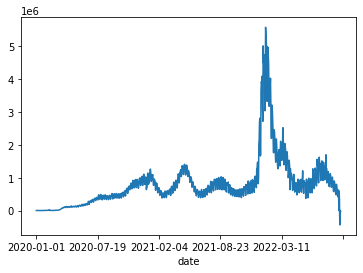

In [3]:
epidemiology_lim.groupby('date',sort=False).sum()['new_confirmed'].plot()

In [5]:
epidemiology_lim.describe()

,new_confirmed,new_deceased
count,3.235910e+05,322420.000000
mean,2.519603e+03,27.785516
std,1.443283e+04,477.408985
min,-4.778660e+05,-63811.000000
25%,2.000000e+00,0.000000
50%,1.020000e+02,1.000000
75%,9.310000e+02,11.000000
max,1.235521e+06,63830.000000


In [6]:
government_response.describe()

,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,income_support,debt_relief,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
count,302415.000000,302243.000000,302068.000000,301981.000000,301845.000000,302074.000000,302034.000000,300241.000000,286963.000000,286854.00000,1.467490e+05,1.466450e+05,302001.000000,300377.000000,298180.000000,1.510990e+05,2.327340e+05,301618.000000,301242.000000,301587.000000
mean,1.471319,1.304182,1.245832,2.210308,0.500678,0.839917,0.899213,2.497783,0.739803,0.86293,1.218849e+08,6.164138e+06,1.866603,2.183563,1.398179,6.057794e+06,8.375711e+05,2.383412,2.531290,49.302817
std,1.075089,0.944901,0.788635,1.634293,0.660792,0.871215,0.834520,1.256683,0.733602,0.79253,1.034520e+10,2.180872e+09,0.454062,0.911950,0.733255,7.750679e+08,2.137846e+08,1.237948,2.277946,22.246811
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,2.000000,2.000000,1.000000,0.000000e+00,0.000000e+00,2.000000,0.000000,34.720000
50%,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,3.000000,1.000000,1.00000,0.000000e+00,0.000000e+00,2.000000,2.000000,2.000000,0.000000e+00,0.000000e+00,3.000000,3.000000,50.930000
75%,2.000000,2.000000,2.000000,4.000000,1.000000,2.000000,2.000000,3.000000,1.000000,2.00000,0.000000e+00,0.000000e+00,2.000000,3.000000,2.000000,0.000000e+00,0.000000e+00,3.000000,5.000000,65.740000
max,3.000000,3.000000,2.000000,4.000000,2.000000,3.000000,2.000000,4.000000,2.000000,2.00000,1.957600e+12,8.343531e+11,2.000000,3.000000,2.000000,2.424000e+11,1.004046e+11,4.000000,5.000000,100.000000


## 2.2 Data Preparation

In [7]:
#Top regions where most new cases are detected
location_wise=epidemiology_lim.groupby('location_key',sort=False).sum().sort_values('new_confirmed', ascending=False)
location_wise['share']=location_wise['new_confirmed']*100/(location_wise['new_confirmed'].sum())
location_wise['cum_share']=location_wise['share'].cumsum()
location_wise[location_wise['cum_share']<=30]

,new_confirmed,new_deceased,share,cum_share
location_key,,,,
US,91790598.0,988028.0,11.260519,11.260519
IN,44516479.0,528250.0,5.461111,16.721630
FR,35203157.0,131288.0,4.318588,21.040219
BR,34581186.0,685203.0,4.242287,25.282506
DE,32604993.0,148728.0,3.999856,29.282362


In [8]:
#Limiting analysis for these top 5 countries
epidemiology_lim_reg=epidemiology_lim[epidemiology_lim['location_key'].isin(['US','IN','FR','BR','DE'])]
#Joining epidemiology with government_response dataset
data=epidemiology_lim_reg.merge(government_response, on=['location_key','date'], how='inner')
data=data.fillna(0)
#Limiting analyss to period of high covid activity
data=data[data['date']>='2020-06-01']
data=data[data['date']<='2022-09-15']

#Calculating forward looking moving average to understand impact of government restrictions
data['MA7'] = data.groupby('location_key').rolling(7)['new_confirmed'].mean().reset_index(drop=True).shift(-7)
data=data[~data['MA7'].isna()]
data.fillna(0, inplace=True)

#dropping columns not needed for building prediction model
cols=list(data.columns)
for i in ['new_confirmed','new_deceased','date','location_key']:
    cols.remove(i)

In [9]:
cols.remove('MA7')  
# the independent variables set
X = data[cols]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                               feature        VIF
0                       school_closing   3.137943
1                    workplace_closing   4.829982
2                 cancel_public_events   4.344164
3           restrictions_on_gatherings   4.777965
4             public_transport_closing   4.219948
5            stay_at_home_requirements   3.707449
6    restrictions_on_internal_movement   3.025291
7        international_travel_controls   2.982962
8                       income_support   2.759152
9                          debt_relief   2.382865
10                     fiscal_measures   1.088990
11               international_support   1.931897
12        public_information_campaigns  95.838921
13                      testing_policy   1.855051
14                     contact_tracing   1.985205
15  emergency_investment_in_healthcare   1.010287
16              investment_in_vaccines   2.028485
17                    facial_coverings   2.520270
18                  vaccination_policy   2.898647


In [11]:
#dropping columns not needed for building prediction model
cols=list(data.columns)
for i in ['new_confirmed','new_deceased','date','location_key','public_information_campaigns','stringency_index']:
    cols.remove(i)
    
#Scaling the data
std_scaler = MinMaxScaler()#StandardScaler()
df_scaled = std_scaler.fit_transform(data[cols].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=cols)

In [13]:
df_scaled.corr()

,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,income_support,debt_relief,fiscal_measures,international_support,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,MA7
school_closing,1.000000,0.679372,0.607311,0.546112,0.427391,0.535870,0.390904,0.162570,-0.168714,0.126531,0.001882,0.005964,-0.259597,-0.057148,0.028782,0.008246,0.428457,-0.406239,-0.074633
workplace_closing,0.679372,1.000000,0.698978,0.615019,0.475422,0.424547,0.483554,0.124320,-0.142785,-0.115996,0.003000,-0.002640,-0.301982,-0.128676,0.033556,-0.001416,0.487895,-0.306889,-0.047495
cancel_public_events,0.607311,0.698978,1.000000,0.735655,0.384694,0.231572,0.418818,0.285733,0.100022,-0.190913,-0.011553,0.012675,0.014233,-0.033439,0.011069,0.014301,0.265754,-0.284814,-0.188095
restrictions_on_gatherings,0.546112,0.615019,0.735655,1.000000,0.120697,0.261522,0.126708,0.323389,0.272659,-0.045231,0.012742,0.016498,0.076005,0.124349,0.002683,0.009243,0.250174,-0.400637,-0.143325
public_transport_closing,0.427391,0.475422,0.384694,0.120697,1.000000,0.178284,0.562498,0.072863,-0.446075,0.116220,-0.026956,-0.014011,-0.235730,-0.228768,-0.013650,-0.007383,0.255429,0.077476,0.011528
stay_at_home_requirements,0.535870,0.424547,0.231572,0.261522,0.178284,1.000000,0.268615,-0.172795,-0.368334,0.303973,-0.027691,-0.016282,-0.351158,-0.018599,0.012662,-0.017679,0.552948,-0.080026,0.127955
restrictions_on_internal_movement,0.390904,0.483554,0.418818,0.126708,0.562498,0.268615,1.000000,-0.063873,-0.312589,-0.011975,0.000352,0.018625,-0.351545,-0.290337,0.017187,0.021018,0.321857,-0.095507,0.065871
international_travel_controls,0.162570,0.124320,0.285733,0.323389,0.072863,-0.172795,-0.063873,1.000000,0.084516,-0.049475,0.012510,0.023446,0.316660,-0.055508,-0.035812,0.017524,-0.068413,-0.172637,-0.127151
income_support,-0.168714,-0.142785,0.100022,0.272659,-0.446075,-0.368334,-0.312589,0.084516,1.000000,-0.375929,0.021850,0.001052,0.368150,0.184372,-0.028115,0.008929,-0.408377,-0.147412,-0.147047
debt_relief,0.126531,-0.115996,-0.190913,-0.045231,0.116220,0.303973,-0.011975,-0.049475,-0.375929,1.000000,0.017325,0.030631,-0.105274,0.355726,-0.016674,0.023300,0.295188,-0.296956,-0.015443


## 3.2.1 Frequentist Approach

In [15]:
cols.remove('MA7')
# Assume you have independent variables X and a dependent variable y
X = np.array(df_scaled[cols])
y = np.array(df_scaled[['MA7']])
 
# Create an instance of the LinearRegression class
reg = LinearRegression()
 
# Fit the model to the data
reg.fit(X, y)
 
dict_={}
for i in range(len(cols)):
    dict_[cols[i]]=reg.coef_[0][i]
    
dict_

{'school_closing': -0.022861586377431402,
 'workplace_closing': -0.021692299302881635,
 'cancel_public_events': -0.13727982795984045,
 'restrictions_on_gatherings': 0.03664394061535834,
 'public_transport_closing': 0.017601247524614096,
 'stay_at_home_requirements': 0.07115295003371967,
 'restrictions_on_internal_movement': 0.041245515293244536,
 'international_travel_controls': 0.003736921015072565,
 'income_support': -0.02039258669242652,
 'debt_relief': -0.06597680914078971,
 'fiscal_measures': -0.008384166429692764,
 'international_support': -0.024982354644046467,
 'testing_policy': 0.0022324325476151415,
 'contact_tracing': 0.02808739242833744,
 'emergency_investment_in_healthcare': -0.013243496943241236,
 'investment_in_vaccines': 0.011227224179217331,
 'facial_coverings': 0.019436932025497206,
 'vaccination_policy': 0.008082862841998084}

## 3.2.2 Bayesian Approach

In [16]:
# p will be the number of predictors + intercept (1 + 1 in this case)
n, p = len(df_scaled), 19

with pm.Model() as m:    
    cancel_public_events = pm.Data("cancel_public_events", df_scaled['cancel_public_events'].to_numpy(), mutable=True)
    income_support = pm.Data("income_support", df_scaled['income_support'].to_numpy(), mutable=True)
    restrictions_on_gatherings = pm.Data("restrictions_on_gatherings", df_scaled['restrictions_on_gatherings'].to_numpy(), mutable=True)
    international_travel_controls = pm.Data("international_travel_controls", df_scaled['international_travel_controls'].to_numpy(), mutable=True)
    testing_policy = pm.Data("testing_policy", df_scaled['testing_policy'].to_numpy(), mutable=True)
    school_closing = pm.Data("school_closing", df_scaled['school_closing'].to_numpy(), mutable=True)
    contact_tracing = pm.Data("contact_tracing", df_scaled['contact_tracing'].to_numpy(), mutable=True)
    workplace_closing = pm.Data("workplace_closing", df_scaled['workplace_closing'].to_numpy(), mutable=True)
    debt_relief = pm.Data("debt_relief", df_scaled['debt_relief'].to_numpy(), mutable=True)
    international_support = pm.Data("international_support", df_scaled['international_support'].to_numpy(), mutable=True)
    investment_in_vaccines = pm.Data("investment_in_vaccines", df_scaled['investment_in_vaccines'].to_numpy(), mutable=True)
    fiscal_measures = pm.Data("fiscal_measures", df_scaled['fiscal_measures'].to_numpy(), mutable=True)
    emergency_investment_in_healthcare = pm.Data("emergency_investment_in_healthcare", df_scaled['emergency_investment_in_healthcare'].to_numpy(), mutable=True)
    public_transport_closing = pm.Data("public_transport_closing", df_scaled['public_transport_closing'].to_numpy(), mutable=True)
    restrictions_on_internal_movement = pm.Data("restrictions_on_internal_movement", df_scaled['restrictions_on_internal_movement'].to_numpy(), mutable=True)
    facial_coverings = pm.Data("facial_coverings", df_scaled['facial_coverings'].to_numpy(), mutable=True)
    vaccination_policy = pm.Data("vaccination_policy", df_scaled['vaccination_policy'].to_numpy(), mutable=True)
    stay_at_home_requirements = pm.Data("stay_at_home_requirements", df_scaled['stay_at_home_requirements'].to_numpy(), mutable=True)

    
    
    y = pm.Data("y", df_scaled['MA7'].to_numpy(), mutable=False)
    
    
    tau = pm.Gamma("tau", 0.001, 0.001)
    beta0 = pm.Normal("beta0_intercept", 0, tau=0.001)
    beta1 = pm.Normal("beta1", 0, tau=0.001)
    beta2 = pm.Normal("beta2", 0, tau=0.001)
    beta3 = pm.Normal("beta3", 0, tau=0.001)
    beta4 = pm.Normal("beta4", 0, tau=0.001)
    beta5 = pm.Normal("beta5", 0, tau=0.001)
    beta6 = pm.Normal("beta6", 0, tau=0.001)
    beta7 = pm.Normal("beta7", 0, tau=0.001)
    beta8 = pm.Normal("beta8", 0, tau=0.001)
    beta9 = pm.Normal("beta10", 0, tau=0.001)
    beta10 = pm.Normal("beta11", 0, tau=0.001)
    beta11 = pm.Normal("beta12", 0, tau=0.001)
    beta12 = pm.Normal("beta13", 0, tau=0.001)
    beta13 = pm.Normal("beta14", 0, tau=0.001)
    beta14 = pm.Normal("beta15", 0, tau=0.001)
    beta15 = pm.Normal("beta16", 0, tau=0.001)
    beta16 = pm.Normal("beta17", 0, tau=0.001)
    beta17 = pm.Normal("beta18", 0, tau=0.001)
    beta18 = pm.Normal("beta19", 0, tau=0.001)
    
    variance = pm.Deterministic("variance", 1 / tau)

    mu = beta0 + beta1*cancel_public_events + beta2*income_support + beta3*restrictions_on_gatherings + beta4*international_travel_controls + beta5*testing_policy + beta6*school_closing + beta7*contact_tracing + beta8*workplace_closing + beta9*debt_relief + beta10*international_support + beta11*investment_in_vaccines + beta12*fiscal_measures + beta13*emergency_investment_in_healthcare + beta14*public_transport_closing + beta15*restrictions_on_internal_movement + beta16*facial_coverings + beta17*vaccination_policy + beta18*stay_at_home_requirements
    
    
    likelihood = pm.Normal("likelihood", mu=mu, tau=tau, observed=y)
    # Bayesian R2 from fat1.odc
    sse = (n - p) * variance
    cy = y - y.mean()
    sst = dot(cy, cy)
    br2 = pm.Deterministic("br2", 1 - sse / sst)
    trace = pm.sample(2000)
    ppc = pm.sample_posterior_predictive(trace)    
    
az.summary(trace, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta0_intercept, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 123 seconds.
Sampling: [likelihood]


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0_intercept,0.117,0.016,0.086,0.148,0.000,0.000,5458.0,5536.0,1.0
beta1,-0.137,0.012,-0.162,-0.113,0.000,0.000,7245.0,6079.0,1.0
beta2,-0.020,0.007,-0.035,-0.006,0.000,0.000,7045.0,6427.0,1.0
beta3,0.037,0.011,0.014,0.059,0.000,0.000,6981.0,6109.0,1.0
beta4,0.004,0.010,-0.014,0.023,0.000,0.000,6906.0,6361.0,1.0
beta5,0.002,0.010,-0.018,0.021,0.000,0.000,7006.0,5997.0,1.0
beta6,-0.023,0.010,-0.043,-0.002,0.000,0.000,7571.0,6102.0,1.0
beta7,0.028,0.007,0.013,0.042,0.000,0.000,6996.0,6332.0,1.0
beta8,-0.022,0.017,-0.056,0.012,0.000,0.000,6506.0,5690.0,1.0
beta10,-0.066,0.008,-0.081,-0.050,0.000,0.000,6623.0,6184.0,1.0


array([[<AxesSubplot:title={'center':'beta0_intercept'}>,
        <AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta3'}>],
       [<AxesSubplot:title={'center':'beta4'}>,
        <AxesSubplot:title={'center':'beta5'}>,
        <AxesSubplot:title={'center':'beta6'}>,
        <AxesSubplot:title={'center':'beta7'}>],
       [<AxesSubplot:title={'center':'beta8'}>,
        <AxesSubplot:title={'center':'beta10'}>,
        <AxesSubplot:title={'center':'beta11'}>,
        <AxesSubplot:title={'center':'beta12'}>],
       [<AxesSubplot:title={'center':'beta13'}>,
        <AxesSubplot:title={'center':'beta14'}>,
        <AxesSubplot:title={'center':'beta15'}>,
        <AxesSubplot:title={'center':'beta16'}>],
       [<AxesSubplot:title={'center':'beta17'}>,
        <AxesSubplot:title={'center':'beta18'}>,
        <AxesSubplot:title={'center':'beta19'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubp

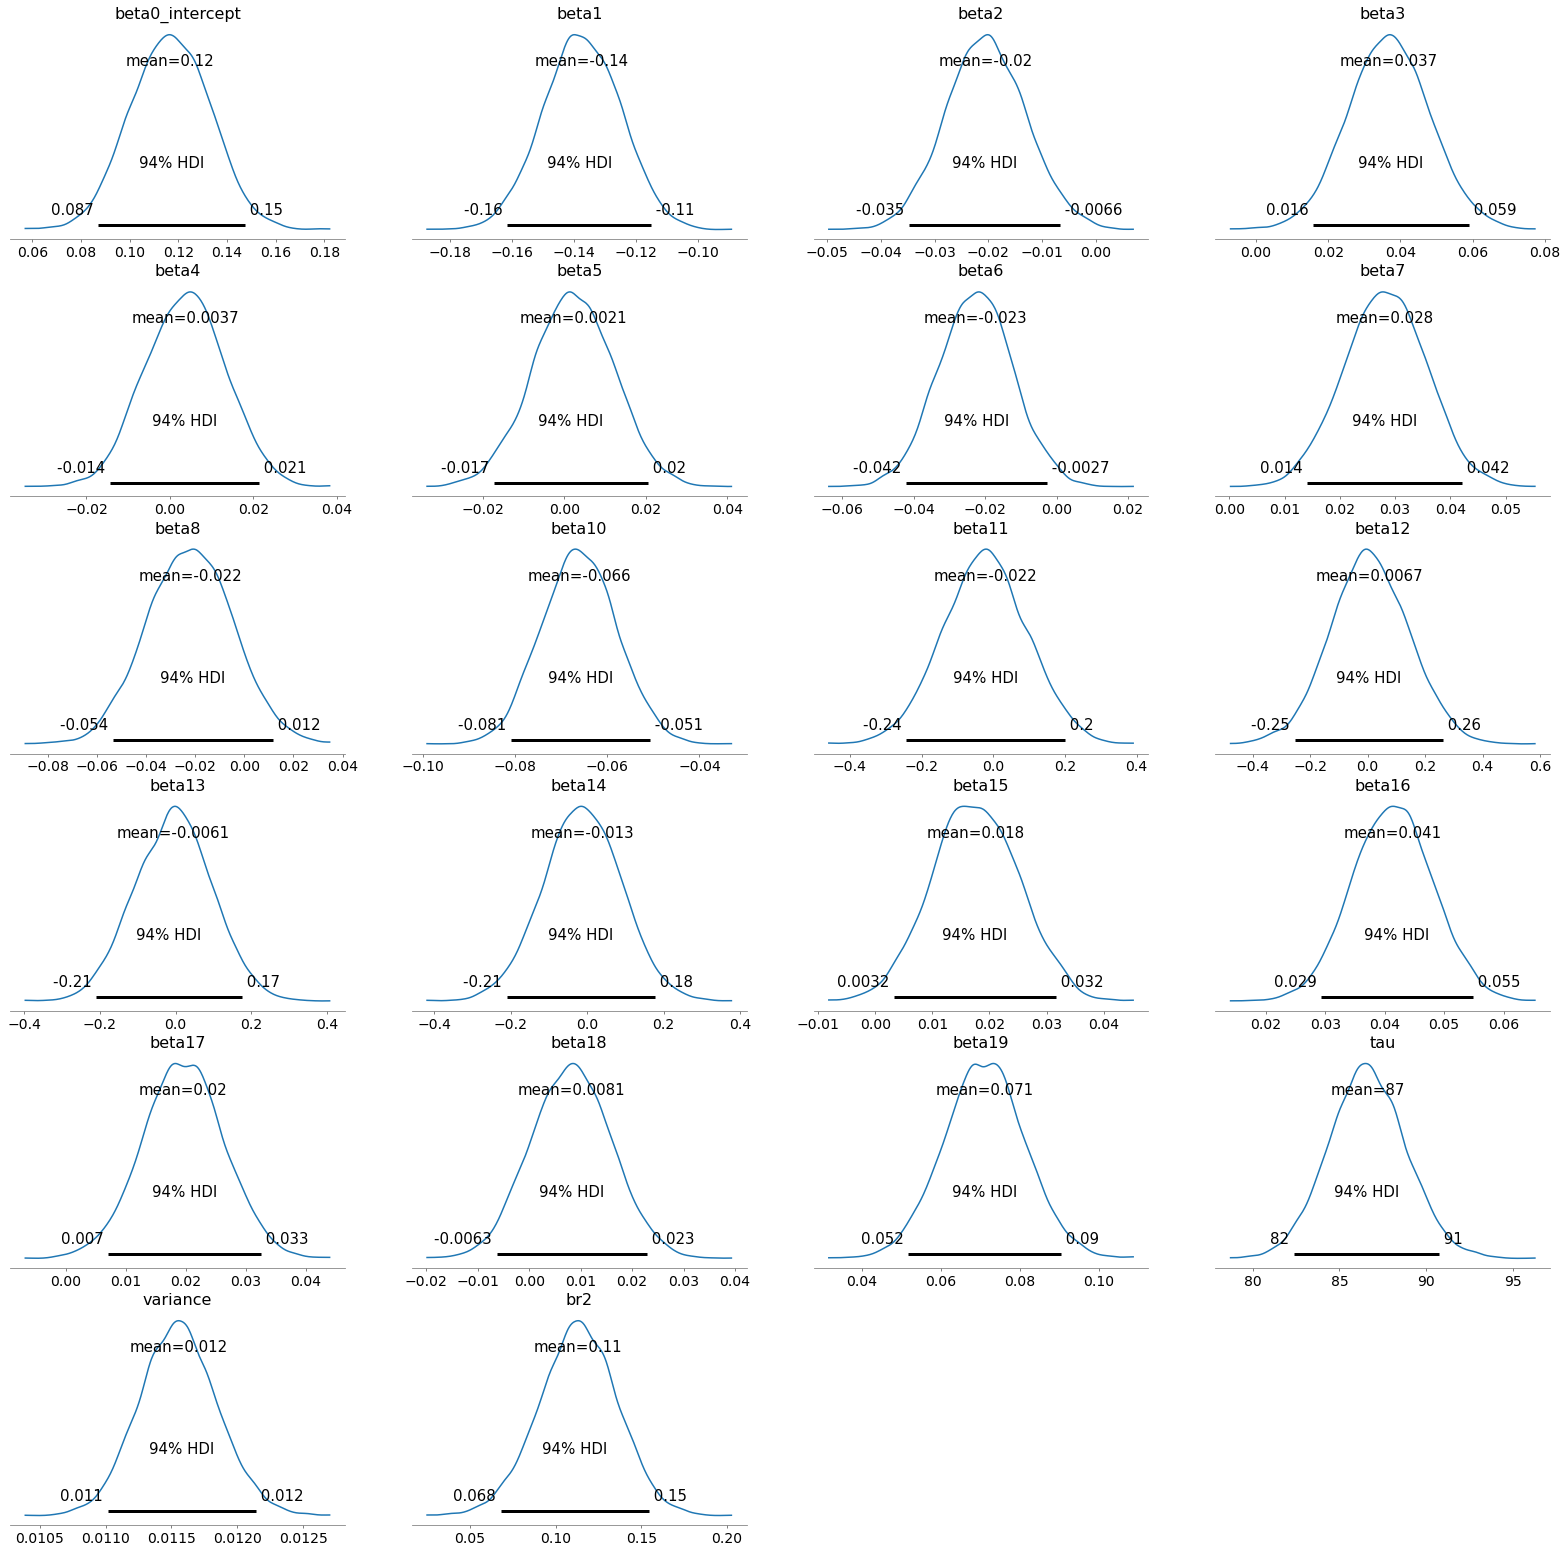

In [17]:
pm.plot_posterior(trace)

## 3.3.1 Bayesian Model for 2020

In [18]:
#----------------1. Building the dataset----------------------------------------------------


#Limiting analysis for these top 5 countries
epidemiology_lim_reg=epidemiology_lim[epidemiology_lim['location_key'].isin(['US','IN','FR','BR','DE'])]
#Joining epidemiology with government_response dataset
data=epidemiology_lim_reg.merge(government_response, on=['location_key','date'], how='inner')
data=data.fillna(0)
#Limiting analyss to period of high covid activity
data=data[pd.to_datetime(data['date']).dt.year==2020]

#Calculating forward looking moving average to understand impact of government restrictions
data['MA7'] = data.groupby('location_key').rolling(7)['new_confirmed'].mean().reset_index(drop=True).shift(-7)
data=data[~data['MA7'].isna()]
data.fillna(0, inplace=True)

#dropping columns not needed for building prediction model
cols=list(data.columns)
for i in ['new_confirmed','new_deceased','date','location_key']:
    cols.remove(i)
    
    
#dropping columns not needed for building prediction model
cols=list(data.columns)
for i in ['new_confirmed','new_deceased','date','location_key','public_information_campaigns','stringency_index']:
    cols.remove(i)
    
#Scaling the data
std_scaler = MinMaxScaler()#StandardScaler()
df_scaled = std_scaler.fit_transform(data[cols].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=cols)



#----------------2. Building the model----------------------------------------------------


# p will be the number of predictors + intercept (1 + 1 in this case)
n, p = len(df_scaled), 19

with pm.Model() as m:    
    cancel_public_events = pm.Data("cancel_public_events", df_scaled['cancel_public_events'].to_numpy(), mutable=True)
    income_support = pm.Data("income_support", df_scaled['income_support'].to_numpy(), mutable=True)
    restrictions_on_gatherings = pm.Data("restrictions_on_gatherings", df_scaled['restrictions_on_gatherings'].to_numpy(), mutable=True)
    international_travel_controls = pm.Data("international_travel_controls", df_scaled['international_travel_controls'].to_numpy(), mutable=True)
    testing_policy = pm.Data("testing_policy", df_scaled['testing_policy'].to_numpy(), mutable=True)
    school_closing = pm.Data("school_closing", df_scaled['school_closing'].to_numpy(), mutable=True)
    contact_tracing = pm.Data("contact_tracing", df_scaled['contact_tracing'].to_numpy(), mutable=True)
    workplace_closing = pm.Data("workplace_closing", df_scaled['workplace_closing'].to_numpy(), mutable=True)
    debt_relief = pm.Data("debt_relief", df_scaled['debt_relief'].to_numpy(), mutable=True)
    international_support = pm.Data("international_support", df_scaled['international_support'].to_numpy(), mutable=True)
    investment_in_vaccines = pm.Data("investment_in_vaccines", df_scaled['investment_in_vaccines'].to_numpy(), mutable=True)
    fiscal_measures = pm.Data("fiscal_measures", df_scaled['fiscal_measures'].to_numpy(), mutable=True)
    emergency_investment_in_healthcare = pm.Data("emergency_investment_in_healthcare", df_scaled['emergency_investment_in_healthcare'].to_numpy(), mutable=True)
    public_transport_closing = pm.Data("public_transport_closing", df_scaled['public_transport_closing'].to_numpy(), mutable=True)
    restrictions_on_internal_movement = pm.Data("restrictions_on_internal_movement", df_scaled['restrictions_on_internal_movement'].to_numpy(), mutable=True)
    facial_coverings = pm.Data("facial_coverings", df_scaled['facial_coverings'].to_numpy(), mutable=True)
    vaccination_policy = pm.Data("vaccination_policy", df_scaled['vaccination_policy'].to_numpy(), mutable=True)
    stay_at_home_requirements = pm.Data("stay_at_home_requirements", df_scaled['stay_at_home_requirements'].to_numpy(), mutable=True)

    
    
    y = pm.Data("y", df_scaled['MA7'].to_numpy(), mutable=False)
    
    
    tau = pm.Gamma("tau", 0.001, 0.001)
    beta0 = pm.Normal("beta0_intercept", 0, tau=0.001)
    beta1 = pm.Normal("beta1", 0, tau=0.001)
    beta2 = pm.Normal("beta2", 0, tau=0.001)
    beta3 = pm.Normal("beta3", 0, tau=0.001)
    beta4 = pm.Normal("beta4", 0, tau=0.001)
    beta5 = pm.Normal("beta5", 0, tau=0.001)
    beta6 = pm.Normal("beta6", 0, tau=0.001)
    beta7 = pm.Normal("beta7", 0, tau=0.001)
    beta8 = pm.Normal("beta8", 0, tau=0.001)
    beta9 = pm.Normal("beta10", 0, tau=0.001)
    beta10 = pm.Normal("beta11", 0, tau=0.001)
    beta11 = pm.Normal("beta12", 0, tau=0.001)
    beta12 = pm.Normal("beta13", 0, tau=0.001)
    beta13 = pm.Normal("beta14", 0, tau=0.001)
    beta14 = pm.Normal("beta15", 0, tau=0.001)
    beta15 = pm.Normal("beta16", 0, tau=0.001)
    beta16 = pm.Normal("beta17", 0, tau=0.001)
    beta17 = pm.Normal("beta18", 0, tau=0.001)
    beta18 = pm.Normal("beta19", 0, tau=0.001)
    
    variance = pm.Deterministic("variance", 1 / tau)

    mu = beta0 + beta1*cancel_public_events + beta2*income_support + beta3*restrictions_on_gatherings + beta4*international_travel_controls + beta5*testing_policy + beta6*school_closing + beta7*contact_tracing + beta8*workplace_closing + beta9*debt_relief + beta10*international_support + beta11*investment_in_vaccines + beta12*fiscal_measures + beta13*emergency_investment_in_healthcare + beta14*public_transport_closing + beta15*restrictions_on_internal_movement + beta16*facial_coverings + beta17*vaccination_policy + beta18*stay_at_home_requirements
    
    
    likelihood = pm.Normal("likelihood", mu=mu, tau=tau, observed=y)
    # Bayesian R2 from fat1.odc
    sse = (n - p) * variance
    cy = y - y.mean()
    sst = dot(cy, cy)
    br2 = pm.Deterministic("br2", 1 - sse / sst)
    trace = pm.sample(2000)
    ppc = pm.sample_posterior_predictive(trace)    
    
az.summary(trace, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta0_intercept, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.
Sampling: [likelihood]


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0_intercept,0.031,0.015,0.004,0.060,0.000,0.000,7477.0,6039.0,1.0
beta1,-0.272,0.048,-0.367,-0.179,0.001,0.000,7249.0,5892.0,1.0
beta2,0.050,0.040,-0.027,0.129,0.000,0.000,6883.0,5600.0,1.0
beta3,0.441,0.056,0.333,0.552,0.001,0.001,6070.0,5477.0,1.0
beta4,-0.167,0.027,-0.219,-0.115,0.000,0.000,6107.0,5321.0,1.0
beta5,-0.078,0.031,-0.137,-0.017,0.000,0.000,6964.0,6304.0,1.0
beta6,0.167,0.037,0.095,0.239,0.000,0.000,6609.0,6175.0,1.0
beta7,0.099,0.021,0.056,0.139,0.000,0.000,7226.0,5800.0,1.0
beta8,-0.274,0.047,-0.370,-0.185,0.001,0.000,6250.0,5885.0,1.0
beta10,0.117,0.024,0.071,0.165,0.000,0.000,6521.0,6077.0,1.0


## 3.3.2 Bayesian Model for 2021

In [19]:
#----------------1. Building the dataset----------------------------------------------------

#Limiting analysis for these top 5 countries
epidemiology_lim_reg=epidemiology_lim[epidemiology_lim['location_key'].isin(['US','IN','FR','BR','DE'])]
#Joining epidemiology with government_response dataset
data=epidemiology_lim_reg.merge(government_response, on=['location_key','date'], how='inner')
data=data.fillna(0)
#Limiting analyss to period of high covid activity
data=data[pd.to_datetime(data['date']).dt.year==2021]

#Calculating forward looking moving average to understand impact of government restrictions
data['MA7'] = data.groupby('location_key').rolling(7)['new_confirmed'].mean().reset_index(drop=True).shift(-7)
data=data[~data['MA7'].isna()]
data.fillna(0, inplace=True)

#dropping columns not needed for building prediction model
cols=list(data.columns)
for i in ['new_confirmed','new_deceased','date','location_key']:
    cols.remove(i)
    
    
#dropping columns not needed for building prediction model
cols=list(data.columns)
for i in ['new_confirmed','new_deceased','date','location_key','public_information_campaigns','stringency_index']:
    cols.remove(i)
    
#Scaling the data
std_scaler = MinMaxScaler()#StandardScaler()
df_scaled = std_scaler.fit_transform(data[cols].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=cols)

# p will be the number of predictors + intercept (1 + 1 in this case)
n, p = len(df_scaled), 19


#----------------2. Building the model----------------------------------------------------


with pm.Model() as m:    
    cancel_public_events = pm.Data("cancel_public_events", df_scaled['cancel_public_events'].to_numpy(), mutable=True)
    income_support = pm.Data("income_support", df_scaled['income_support'].to_numpy(), mutable=True)
    restrictions_on_gatherings = pm.Data("restrictions_on_gatherings", df_scaled['restrictions_on_gatherings'].to_numpy(), mutable=True)
    international_travel_controls = pm.Data("international_travel_controls", df_scaled['international_travel_controls'].to_numpy(), mutable=True)
    testing_policy = pm.Data("testing_policy", df_scaled['testing_policy'].to_numpy(), mutable=True)
    school_closing = pm.Data("school_closing", df_scaled['school_closing'].to_numpy(), mutable=True)
    contact_tracing = pm.Data("contact_tracing", df_scaled['contact_tracing'].to_numpy(), mutable=True)
    workplace_closing = pm.Data("workplace_closing", df_scaled['workplace_closing'].to_numpy(), mutable=True)
    debt_relief = pm.Data("debt_relief", df_scaled['debt_relief'].to_numpy(), mutable=True)
    international_support = pm.Data("international_support", df_scaled['international_support'].to_numpy(), mutable=True)
    investment_in_vaccines = pm.Data("investment_in_vaccines", df_scaled['investment_in_vaccines'].to_numpy(), mutable=True)
    fiscal_measures = pm.Data("fiscal_measures", df_scaled['fiscal_measures'].to_numpy(), mutable=True)
    emergency_investment_in_healthcare = pm.Data("emergency_investment_in_healthcare", df_scaled['emergency_investment_in_healthcare'].to_numpy(), mutable=True)
    public_transport_closing = pm.Data("public_transport_closing", df_scaled['public_transport_closing'].to_numpy(), mutable=True)
    restrictions_on_internal_movement = pm.Data("restrictions_on_internal_movement", df_scaled['restrictions_on_internal_movement'].to_numpy(), mutable=True)
    facial_coverings = pm.Data("facial_coverings", df_scaled['facial_coverings'].to_numpy(), mutable=True)
    vaccination_policy = pm.Data("vaccination_policy", df_scaled['vaccination_policy'].to_numpy(), mutable=True)
    stay_at_home_requirements = pm.Data("stay_at_home_requirements", df_scaled['stay_at_home_requirements'].to_numpy(), mutable=True)

    
    
    y = pm.Data("y", df_scaled['MA7'].to_numpy(), mutable=False)
    
    
    tau = pm.Gamma("tau", 0.001, 0.001)
    beta0 = pm.Normal("beta0_intercept", 0, tau=0.001)
    beta1 = pm.Normal("beta1", 0, tau=0.001)
    beta2 = pm.Normal("beta2", 0, tau=0.001)
    beta3 = pm.Normal("beta3", 0, tau=0.001)
    beta4 = pm.Normal("beta4", 0, tau=0.001)
    beta5 = pm.Normal("beta5", 0, tau=0.001)
    beta6 = pm.Normal("beta6", 0, tau=0.001)
    beta7 = pm.Normal("beta7", 0, tau=0.001)
    beta8 = pm.Normal("beta8", 0, tau=0.001)
    beta9 = pm.Normal("beta10", 0, tau=0.001)
    beta10 = pm.Normal("beta11", 0, tau=0.001)
    beta11 = pm.Normal("beta12", 0, tau=0.001)
    beta12 = pm.Normal("beta13", 0, tau=0.001)
    beta13 = pm.Normal("beta14", 0, tau=0.001)
    beta14 = pm.Normal("beta15", 0, tau=0.001)
    beta15 = pm.Normal("beta16", 0, tau=0.001)
    beta16 = pm.Normal("beta17", 0, tau=0.001)
    beta17 = pm.Normal("beta18", 0, tau=0.001)
    beta18 = pm.Normal("beta19", 0, tau=0.001)
    
    variance = pm.Deterministic("variance", 1 / tau)

    mu = beta0 + beta1*cancel_public_events + beta2*income_support + beta3*restrictions_on_gatherings + beta4*international_travel_controls + beta5*testing_policy + beta6*school_closing + beta7*contact_tracing + beta8*workplace_closing + beta9*debt_relief + beta10*international_support + beta11*investment_in_vaccines + beta12*fiscal_measures + beta13*emergency_investment_in_healthcare + beta14*public_transport_closing + beta15*restrictions_on_internal_movement + beta16*facial_coverings + beta17*vaccination_policy + beta18*stay_at_home_requirements
    
    
    likelihood = pm.Normal("likelihood", mu=mu, tau=tau, observed=y)
    # Bayesian R2 from fat1.odc
    sse = (n - p) * variance
    cy = y - y.mean()
    sst = dot(cy, cy)
    br2 = pm.Deterministic("br2", 1 - sse / sst)
    trace = pm.sample(2000)
    ppc = pm.sample_posterior_predictive(trace)    
    
az.summary(trace, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta0_intercept, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 79 seconds.
Sampling: [likelihood]


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0_intercept,-0.232,0.085,-0.405,-0.071,0.002,0.001,2623.0,4050.0,1.0
beta1,0.018,0.021,-0.022,0.059,0.000,0.000,8517.0,6198.0,1.0
beta2,0.105,0.046,0.012,0.192,0.001,0.001,2980.0,4592.0,1.0
beta3,0.066,0.019,0.027,0.102,0.000,0.000,7242.0,6107.0,1.0
beta4,0.075,0.020,0.037,0.116,0.000,0.000,6277.0,6226.0,1.0
beta5,0.037,0.025,-0.011,0.088,0.000,0.000,3624.0,5451.0,1.0
beta6,-0.099,0.023,-0.145,-0.054,0.000,0.000,4008.0,5380.0,1.0
beta7,0.123,0.023,0.079,0.170,0.000,0.000,3531.0,5109.0,1.0
beta8,0.043,0.018,0.009,0.077,0.000,0.000,6417.0,6049.0,1.0
beta10,-0.250,31.413,-64.687,58.341,0.297,0.383,11223.0,5500.0,1.0
